# 🧩 1. Introducción
Este análisis explora la distribución y características de delitos reportados en Los Ángeles, enfocándose en la relación entre el tipo de crimen, el horario del día, y características de las víctimas como edad y género. Se busca responder:
¿Cómo se distribuyen los delitos según el horario y las características de las víctimas (edad, sexo, uso de armas)?


## Dataset
Para responder estas preguntas mediante visualizaciones, se hizo uso del dataset sobre delincuencia desde 2020 hasta la actualidad ("Crime Data from 2020 to Present") del Departamento Policial de Los Angeles (LAPD). 
Se puede acceder al dataset mediante este link: https://catalog.data.gov/dataset/crime-data-from-2020-to-present


## 📥 Adquisición

El archivo descargado fue convertido y cargado al entorno de análisis como un archivo CSV para luego convertirlo a un dataframe.

In [271]:
import pandas as pd
path = 'Data.csv'
data = pd.read_csv(path)

## 🔎 Parseo y estructuración

En esta etapa, es de interes convertir los datos en una estructura util informarnos acerca de que tipo de datos se encuentran presentes.

Como se puede ver, el dataset contiene informacion sobre cada crimen reportado, incluyendo los codigos del crimen y su descripcion (Crm Cd 1-4, Crm Cd Desc), fecha y hora del crimen (DATE OCC, TIME OCC), edad y sexo de la victima (Vict Age, Vict Sex) y uso de armas (Weapon Used Cd), entre mas atributos.

Contiene informacion de 1.005.109 de crimenes reportados.

In [272]:
print(f'El dataset tiene {data.shape[1]} columnas y {data.shape[0]} filas')
data.head()

El dataset tiene 28 columnas y 1005109 filas


,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,190326475,03/01/2020 12:00:00 AM,03/01/2020 12:00:00 AM,2130,7,Wilshire,784,1,510,VEHICLE - STOLEN,...,AA,Adult Arrest,510.0,998.0,NaN,NaN,1900 S LONGWOOD AV,NaN,34.0375,-118.3506
1,200106753,02/09/2020 12:00:00 AM,02/08/2020 12:00:00 AM,1800,1,Central,182,1,330,BURGLARY FROM VEHICLE,...,IC,Invest Cont,330.0,998.0,NaN,NaN,1000 S FLOWER ST,NaN,34.0444,-118.2628
2,200320258,11/11/2020 12:00:00 AM,11/04/2020 12:00:00 AM,1700,3,Southwest,356,1,480,BIKE - STOLEN,...,IC,Invest Cont,480.0,NaN,NaN,NaN,1400 W 37TH ST,NaN,34.0210,-118.3002
3,200907217,05/10/2023 12:00:00 AM,03/10/2020 12:00:00 AM,2037,9,Van Nuys,964,1,343,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),...,IC,Invest Cont,343.0,NaN,NaN,NaN,14000 RIVERSIDE DR,NaN,34.1576,-118.4387
4,200412582,09/09/2020 12:00:00 AM,09/09/2020 12:00:00 AM,630,4,Hollenbeck,413,1,510,VEHICLE - STOLEN,...,IC,Invest Cont,510.0,NaN,NaN,NaN,200 E AVENUE 28,NaN,34.0820,-118.2130


Para preparar un subconjunto relevante de nuestros datos, vamos a comenzar por crear un nuevo dataframe (df) unicamente con las columnas relevantes al analisis.

Las columnas de nuestro interes son: dia del crimen, hora del crimen, edad de la victima, codigo de arma utilizada, sexo de la victima y codigo de crimen 1-4.

In [273]:
# Seleccionar columnas relevantes para el análisis
columnas_df1 = ['DATE OCC', 'TIME OCC', 'Vict Age', 'Weapon Used Cd', 'Vict Sex', 'Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4']
df1 = data[columnas_df1].copy()

El tipo de dato DATE OCC no es el correcto, lo cambiamos a formato datetime, el cual nos va a permitir tambien crear una nueva columna donde se especifique el dia de la semana del crimen.

In [274]:
# Parsear la fecha y extraer el día de la semana
df1['DATE OCC'] = pd.to_datetime(df1['DATE OCC'], format='%m/%d/%Y %I:%M:%S %p')
df1['DayOfWeek'] = df1['DATE OCC'].dt.day_name()

Luego, en las columnas Crm Cd 1-4, tenemos el codigo del tipo de crimen, pero nos interesa la descripcion del mismo.

Para solucionar esto, primero se mapea en un diccionario cada codigo de crimen junto a su descripcion, basandonos en el dataframe original.

Este diccionario lo vamos a usar mas adelante para visualizar correctamente el tipo de crimen, en lugar de su codigo.

In [275]:
# Crear un diccionario con Crime Code como clave y su descripción como valor
crime_code_dict = data[['Crm Cd', 'Crm Cd Desc']].drop_duplicates().set_index('Crm Cd')['Crm Cd Desc'].to_dict()

## 🧼 Limpieza y filtrado de datos

En el df1, vamos a descartar las filas que no tengan codigo de crimen principal (Crm Cd 1) y que no tienen registrada la hora en la que ocurrio. 

Tambien vamos a eliminar instancias cuya edad de victima sea ilogica.

In [276]:
# Ver valores nulos
df1.isna().sum()

DATE OCC                0
TIME OCC                0
Vict Age                0
Weapon Used Cd     677850
Vict Sex           144730
Crm Cd 1               11
Crm Cd 2           935955
Crm Cd 3          1002795
Crm Cd 4          1005045
DayOfWeek               0
dtype: int64

In [277]:
# Eliminar filas con código de crimen principal nulo
df1 = df1.dropna(subset=['Crm Cd 1'])
print('Se eliminaron {} filas con valores nulos'.format(data.shape[0] - df1.shape[0]))

Se eliminaron 11 filas con valores nulos


In [278]:
# Eliminar edades fuera de rango razonable
filas_antes = df1.shape[0]
df1 = df1[(df1['Vict Age'] >= 5) & (df1['Vict Age'] <= 95) & df1['Vict Age'].notna()]
print('Se eliminaron {} filas con edades fuera de rango razonable'.format(filas_antes - df1.shape[0]))

Se eliminaron 271491 filas con edades fuera de rango razonable


El conteo de valores unicos del sexo de la victima muestra que hay muy pocos con el valor H. Esto lo hace irrelevante al analisis y por lo tanto los descartamos.

In [279]:
df1['Vict Sex'].value_counts()

Vict Sex
M    369361
F    353662
X     10441
H       112
Name: count, dtype: int64

In [280]:
df1 = df1[df1['Vict Sex'] != 'H']

## 🔧 Transformaciones

Agrupamos los crimenes segun el intervalo horario en el que ocurrieron.

Por ejemplo, si un crimen ocurrio entre 11:30 y 12:30, se le asigna el intervalo 12

In [281]:
# Agregar columna de intervalo horario
df1['Intervalo Horario'] = ((df1['TIME OCC'] // 100) + (df1['TIME OCC'] % 100 >= 30)).astype(int)

En la columna Weapon Used Cd se encuentra el codigo del tipo de arma utilizada o NaN si no se utilizo ninguna arma, pero a nosotros nos interesa solamente saber si se utilizo o no, mas alla del tipo.

Entonces, creamos una nueva columna con valores True o False, dependiendo si se utilizo arma. Despues descartamos la columna Weapon Used Cd.

In [282]:
# Crear columna binaria de uso de arma
df1['Weapon Used'] = df1['Weapon Used Cd'].notna()

Para lograr una visualizacion mas limpia y con menos ruido, vamos a seleccionar unicamente las 6 catagorias con mas crimenes reportados en total.

Cada categoria de crimen suma un crimen si aparece en cualquier columna Crm Cd 1-4

In [283]:
# Obtener los crímenes más comunes entre todas las columnas
all_crime_codes = pd.concat([df1['Crm Cd 1'], df1['Crm Cd 2'], df1['Crm Cd 3'], df1['Crm Cd 4']])
top_categorias = all_crime_codes.value_counts().head(6).index.tolist()

Para el conteo, nos interesa formar una tabla de la distribucion a lo largo de las horas de las frecuencias relativas por tipo de crimen.
Las columnas de este df seran Crm Cd y luego intervalos de horarios del 1 al 24.

La ultima columna representa la suma de frecuencias. "value_counts(normalize=True)" trabaja con floats, y al hacer la suma se espera que el total sea exactamente 1, pero debido a pequeños errores de redondeo flotante, puede dar algo como 0.99999999999 o 1.0000001

In [284]:
# Tabla de frecuencias relativas por crimen y hora
conteo_df = pd.DataFrame(columns=['Crimen'] + list(range(1, 25)))
for codigo in top_categorias:
    filtro = df1[df1['Crm Cd 1'] == codigo]
    frecuencias = filtro['Intervalo Horario'].value_counts(normalize=True).reindex(range(1, 25), fill_value=0)
    temp_df = pd.DataFrame([{'Crimen': codigo, **frecuencias.to_dict()}])
    temp_df['Total'] = temp_df.iloc[:, 1:].sum(axis=1)
    conteo_df = pd.concat([conteo_df, temp_df], ignore_index=True)

conteo_df.head()

C:\Users\puigg\AppData\Local\Temp\ipykernel_16232\2269419694.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  conteo_df = pd.concat([conteo_df, temp_df], ignore_index=True)


,Crimen,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,Total
0,624.0,0.028065,0.025703,0.016591,0.012042,0.010192,0.012312,0.019925,0.031292,0.038379,...,0.062962,0.061045,0.060532,0.057076,0.056441,0.053633,0.049948,0.040728,0.018062,0.981317
1,330.0,0.034490,0.026952,0.024158,0.021331,0.018553,0.017367,0.019414,0.023540,0.023557,...,0.043165,0.057397,0.070280,0.080872,0.086071,0.074081,0.073496,0.060678,0.022062,0.974916
2,354.0,0.030476,0.015678,0.010963,0.008891,0.010164,0.046790,0.043625,0.062746,0.054947,...,0.041455,0.037491,0.030590,0.024456,0.020230,0.016233,0.014797,0.011094,0.005971,0.912995
3,230.0,0.041661,0.040064,0.027365,0.019750,0.015990,0.015406,0.020120,0.024891,0.030696,...,0.054263,0.052607,0.054633,0.054749,0.059950,0.058703,0.059190,0.053230,0.025242,0.975634
4,626.0,0.048610,0.041902,0.033776,0.024531,0.020016,0.016469,0.020725,0.028573,0.032099,...,0.039150,0.043923,0.047471,0.047836,0.057876,0.063101,0.066476,0.064735,0.029282,0.969256


## 📊 Visualización 1: Heatmap de crímenes por hora

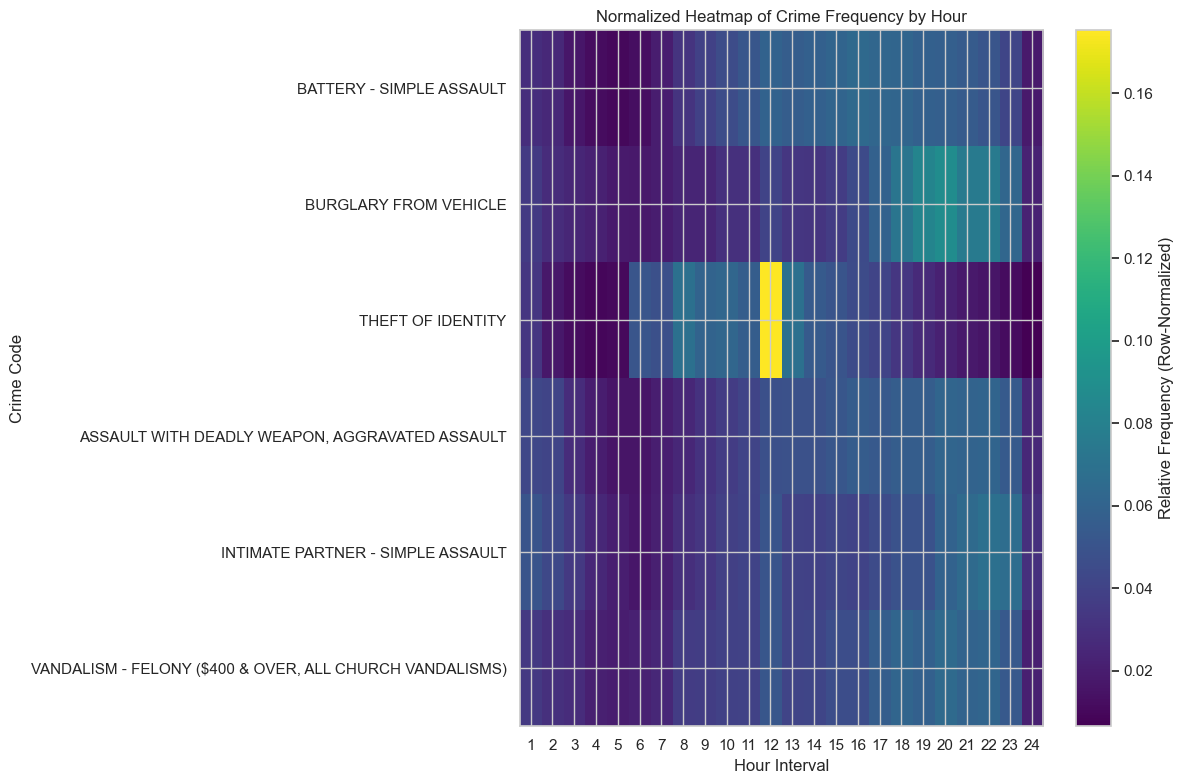

In [294]:
import numpy as np
import matplotlib.pyplot as plt

heatmap_data = conteo_df.iloc[:, 1:25].values
y_labels = [crime_code_dict.get(code, str(code)) for code in conteo_df['Crimen'].astype(int).tolist()]
x_labels = list(range(1, 25))
normalized = heatmap_data / heatmap_data.sum(axis=1, keepdims=True)

plt.figure(figsize=(12, 8))
plt.imshow(normalized, aspect='auto', cmap='viridis', interpolation='nearest')
plt.xticks(ticks=np.arange(len(x_labels)), labels=x_labels)
plt.yticks(ticks=np.arange(len(y_labels)), labels=y_labels)
plt.colorbar(label='Relative Frequency (Row-Normalized)')
plt.xlabel('Hour Interval')
plt.ylabel('Crime Code')
plt.title('Normalized Heatmap of Crime Frequency by Hour')
plt.tight_layout()
plt.show()

### Refinamiento del Heatmap

En esta etapa, se mejora la presentación visual del heatmap original con el objetivo de facilitar su interpretación y hacer más clara la comparación entre categorías. Se aplican los siguientes cambios:

- **Uso de Seaborn:** se utiliza `sns.heatmap()` en lugar de `plt.imshow()` para obtener un gráfico más limpio y profesional, con soporte directo para etiquetas, grillas y barra de color personalizada.
- **Paleta de colores `coolwarm`:** reemplaza a `viridis` para ofrecer un mayor contraste entre valores bajos y altos, facilitando la identificación de patrones horarios marcados.
- **Normalización del rango de color (`vmax`)**: se establece un límite superior como la media + 1.5 desviaciones estándar, evitando que un solo valor extremo domine toda la escala de color.
- **Etiquetas recortadas:** los nombres de crímenes demasiado largos se recortan y se les agrega `"..."` para mantener el orden visual sin perder claridad.
- **Grillas blancas (`linewidths=0.5`)**: se añaden líneas blancas finas para mejorar la lectura entre celdas sin saturar el gráfico.

Estos cambios no alteran los datos representados, pero **aumentan significativamente la legibilidad y estética** del gráfico final.


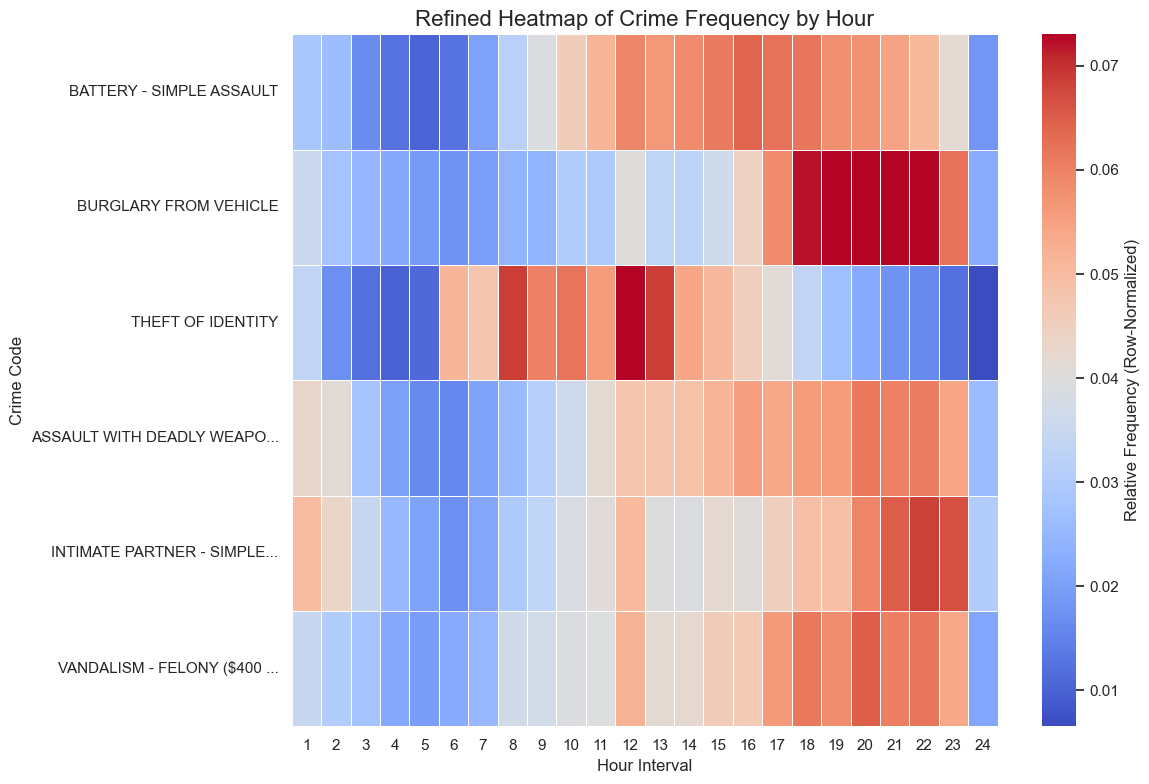

In [286]:
import seaborn as sns
y_labels = [str(label) for label in y_labels]
y_labels = [label if len(label) <= 28 else label[:25] + '...' for label in y_labels]
heatmap_df = pd.DataFrame(normalized, index=y_labels, columns=x_labels)

plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_df,
    cmap='coolwarm',
    annot=False,
    cbar_kws={'label': 'Relative Frequency (Row-Normalized)'},
    linewidths=0.5,
    linecolor='white',
    vmax=normalized.mean() + 1.5 * normalized.std()
)
plt.title('Refined Heatmap of Crime Frequency by Hour', fontsize=16)
plt.xlabel('Hour Interval')
plt.ylabel('Crime Code')
plt.tight_layout()
plt.show()

Este heatmap revela patrones horarios claros y diferenciados entre los distintos tipos de crimen:

“BURGLARY FROM VEHICLE” y “THEFT OF IDENTITY” se concentran en las horas nocturnas (de 17 a 22 hs), lo cual es esperable dado que en esos momentos es más probable que las personas estén fuera de casa, dejando vehículos y documentos expuestos.

En cambio, delitos como “ASSAULT WITH DEADLY WEAPON” y “BATTERY - SIMPLE ASSAULT” tienen una distribución más homogénea a lo largo del día, pero con un leve pico en la tarde-noche, probablemente vinculado a interacciones sociales o consumo de alcohol.

“INTIMATE PARTNER - SIMPLE ASSAULT” muestra mayor ocurrencia al final del día, lo cual puede reflejar tensiones en entornos domésticos durante horarios de convivencia.

✅ Este gráfico permite identificar cuándo ocurren ciertos delitos y sugiere una relación entre el tipo de crimen y el contexto horario, apoyando decisiones de prevención específicas por franja horaria.

## 📈 Visualización 2: Scatterplot Edad vs Hora con uso de arma

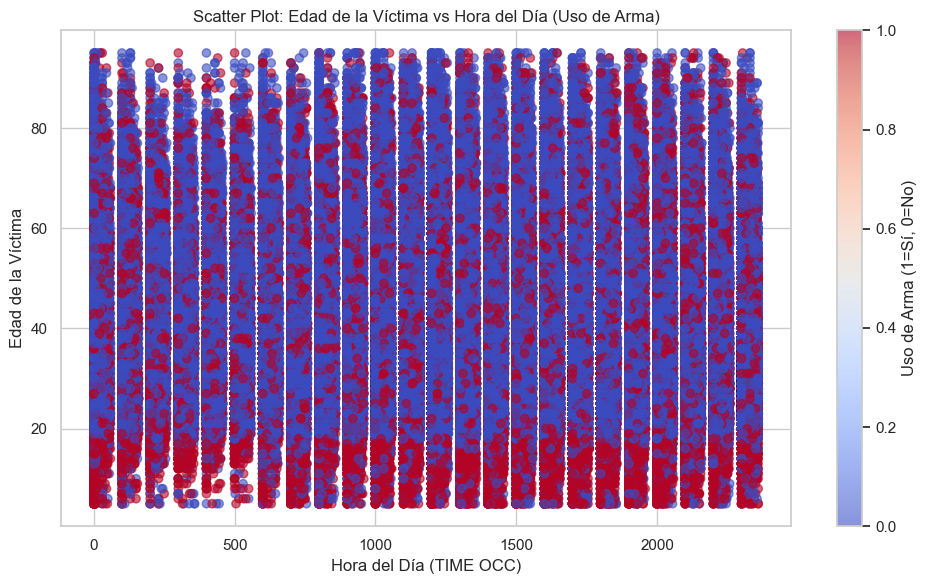

In [287]:
# Crear una nueva columna para indicar si se usó un arma
df1['Weapon Used'] = df1['Weapon Used Cd'].notna()

# Crear el scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df1['TIME OCC'],  # Hora del día (TIME OCC)
    df1['Vict Age'],  # Edad de la víctima
    c=df1['Weapon Used'],  # Color basado en si se usó un arma
    cmap='coolwarm',  # Mapa de colores
    alpha=0.6  # Transparencia
)

# Agregar etiquetas y título
plt.xlabel('Hora del Día (TIME OCC)')
plt.ylabel('Edad de la Víctima')
plt.title('Scatter Plot: Edad de la Víctima vs Hora del Día (Uso de Arma)')
plt.colorbar(scatter, label='Uso de Arma (1=Sí, 0=No)')
plt.tight_layout()
plt.show()

### Refinamiento del Scatter Plot: Hora del Día vs Edad de la Víctima

El gráfico original mostraba la relación entre la edad de la víctima y la hora del crimen, diferenciando con color si se utilizó un arma. Aunque era informativo, presentaba problemas de **superposición de puntos**, especialmente en horas y edades frecuentes, lo que dificultaba la interpretación.

Para mejorar la visualización, se aplicaron los siguientes refinamientos:

- **Conversión de formato horario:**  
  Se convirtió `TIME OCC` al formato decimal (por ejemplo, 13:30 → 13.5) para una escala más precisa en el eje X.
  
- **Aplicación de jitter:**  
  Se agregó un valor aleatorio pequeño a las coordenadas horarias y de edad (`HoraJittered` y `VictAgeJittered`) para evitar superposición de puntos. Esto es útil en datasets grandes donde muchos registros comparten valores idénticos.

- **Colores personalizados y etiquetas legibles:**  
  Se reemplazaron los valores booleanos por categorías `Sí/No`, asignando una paleta de colores (`red` / `blue`) para mayor claridad. Esto también mejora la legibilidad de la leyenda.

- **Transparencia y tamaño reducido de puntos:**  
  Se ajustó el parámetro `alpha` para que puntos superpuestos generen mayor intensidad visual, y se redujo el tamaño de los puntos para mostrar más densidad sin saturar el gráfico.

- **Ticks personalizados:**  
  El eje X fue ajustado para mostrar horas clave del día en formato `"HH:MM"`.

Estos cambios permiten detectar patrones horarios y etarios con mayor claridad, conservando el foco en el objetivo: analizar cómo varía la edad de la víctima según el horario y si se utilizó un arma en el crimen.


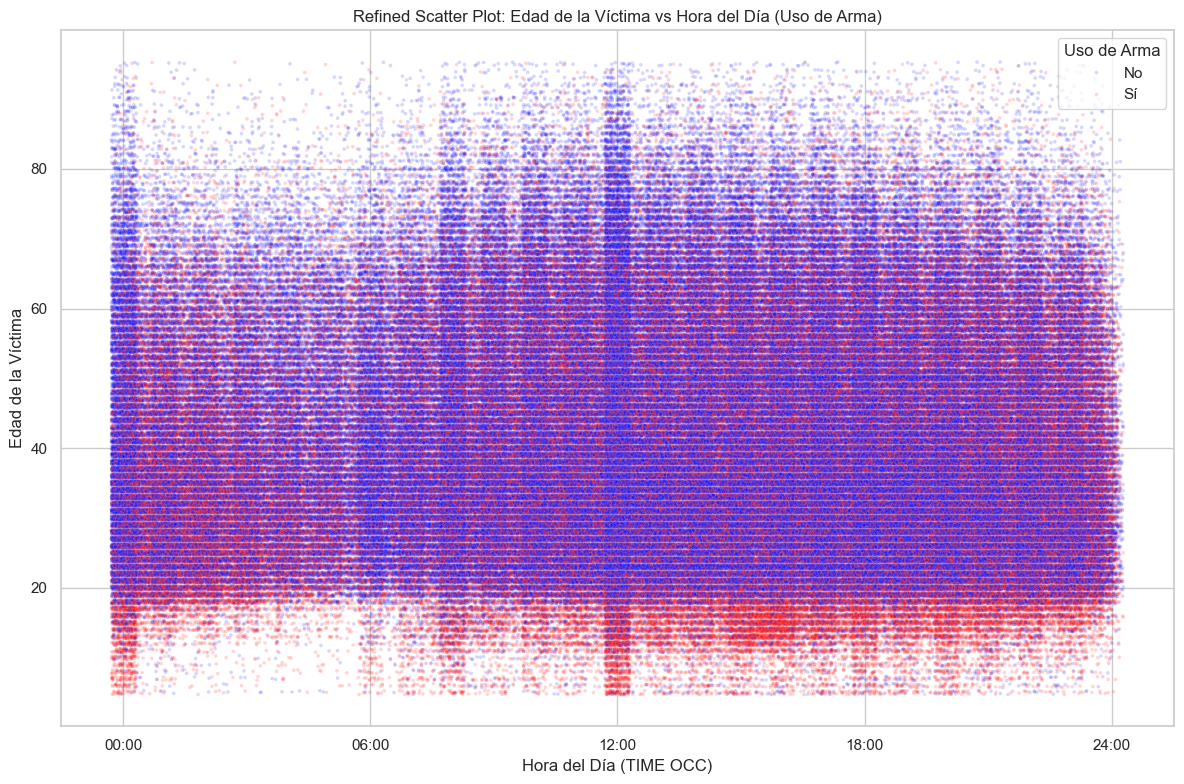

In [288]:
alph_val = 0.16
taman_punto = 7
val_jitter = 0.3

df1['HoraDecimal'] = (df1['TIME OCC'] // 100) + (df1['TIME OCC'] % 100) / 60
df1['HoraJittered'] = df1['HoraDecimal'] + np.random.uniform(-val_jitter, val_jitter, size=len(df1))
df1['VictAgeJittered'] = df1['Vict Age'] + np.random.uniform(-val_jitter, val_jitter, size=len(df1))

df1['Uso de Arma'] = df1['Weapon Used'].map({True: 'Sí', False: 'No'})
palette = {'Sí': 'red', 'No': 'blue'}

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='HoraJittered',
    y='VictAgeJittered',
    hue='Uso de Arma',
    palette=palette,
    data=df1,
    alpha=alph_val,
    s=taman_punto,
)
plt.xlabel('Hora del Día (TIME OCC)')
plt.ylabel('Edad de la Víctima')
plt.xticks(ticks=[0, 6, 12, 18, 24], labels=['00:00', '06:00', '12:00', '18:00', '24:00'])
plt.title('Refined Scatter Plot: Edad de la Víctima vs Hora del Día (Uso de Arma)')
plt.legend(title='Uso de Arma', loc='upper right')
plt.tight_layout()
plt.show()

Este gráfico revela que:

La mayoría de los crímenes ocurren entre personas de 18 a 50 años, lo cual es esperable, ya que representa el grupo etario más activo social y laboralmente.

Las armas se usan en todos los horarios, pero el color rojo (uso de arma) parece ligeramente más denso entre las 18 y 02 hs, lo cual podría sugerir una mayor violencia en horas nocturnas, posiblemente asociada a situaciones como robos o conflictos violentos.

También se observa que el uso de armas afecta mucho mas a victimas jovenes.

✅ Este gráfico conecta la variable edad y el uso de arma con el horario, aportando evidencia visual sobre los momentos del día con mayor riesgo de violencia armada y sobre qué edades son más frecuentemente afectadas.



## 📈 Visualización 2: Barras agrupadas, cantidad de crimenes por franja horaria agrupada por sexo

En una primera aproximación, se agrupan los datos por franja horaria (Intervalo Horario) y sexo de la víctima (Vict Sex), y se utiliza un gráfico de barras básico para visualizar la cantidad de crímenes.

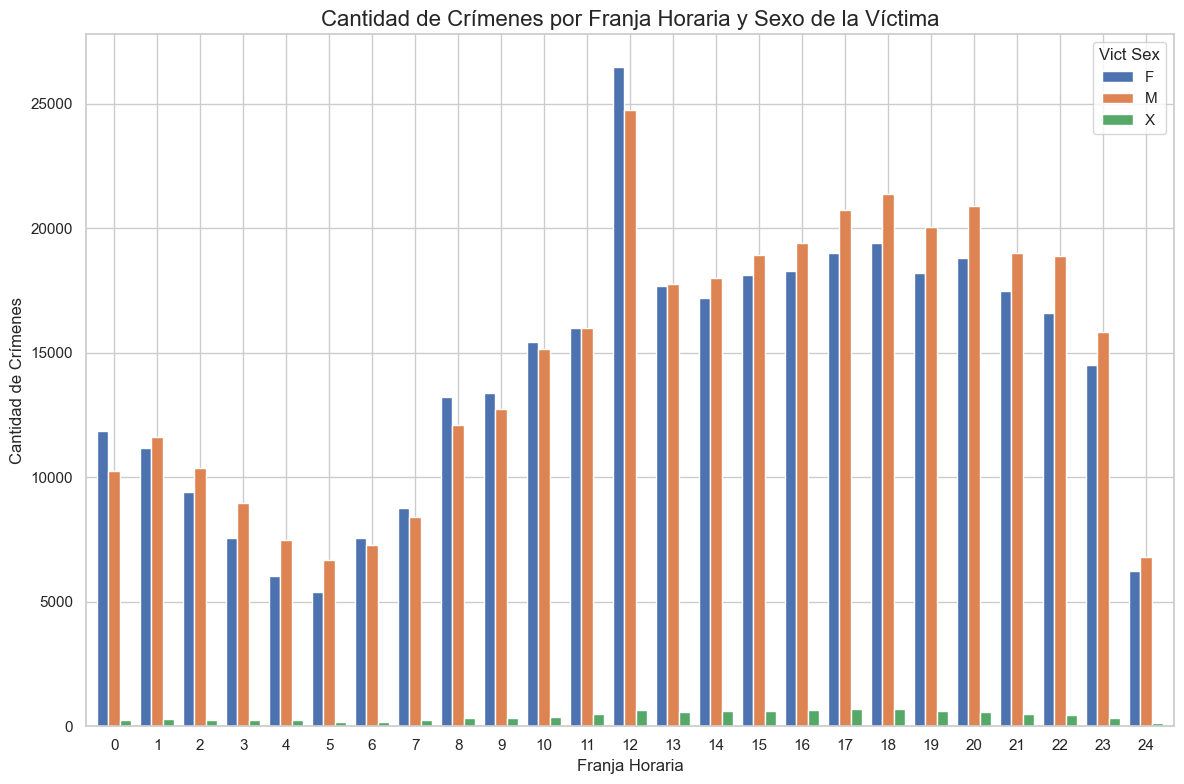

In [ ]:
# Agrupar los datos por franja horaria (Intervalo Horario) y Vict Sex
grouped_data = df1.groupby(['Intervalo Horario', 'Vict Sex']).size().unstack(fill_value=0)


# Crear el gráfico de barras agrupado
grouped_data.plot(kind='bar', figsize=(12, 8), width=0.8)

# Configurar etiquetas y título
plt.title('Cantidad de Crímenes por Franja Horaria y Sexo de la Víctima', fontsize=16)
plt.xlabel('Franja Horaria', fontsize=12)
plt.ylabel('Cantidad de Crímenes', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Vict Sex', loc='upper right')
plt.tight_layout()
plt.show()

Para facilitar el análisis posterior, se transforma el resultado del groupby en un DataFrame más amigable:

Se agrega una columna 'Total' que suma los valores por fila.

Se renombran las columnas para mayor legibilidad.

Se reinicia el índice para obtener un DataFrame plano.

In [290]:
# Agrupar por intervalo horario y sexo de la víctima, y contar las ocurrencias
df_crimenes_por_franja = df1.groupby(['Intervalo Horario', 'Vict Sex']).size().unstack(fill_value=0)

# Agregar una columna con el total de crímenes por intervalo horario
df_crimenes_por_franja['Total'] = df_crimenes_por_franja.sum(axis=1)

# Reiniciar el índice para convertirlo en un DataFrame plano
df_crimenes_por_franja = df_crimenes_por_franja.reset_index()

# Renombrar las columnas para mayor claridad
df_crimenes_por_franja.columns.name = None
df_crimenes_por_franja.rename(columns={'Intervalo Horario': 'Franja Horaria', 'F': 'Cantidad Crímenes F', 'M': 'Cantidad Crímenes M', 'X': 'Cantidad Crímenes X'}, inplace=True)

df_crimenes_por_franja

,Franja Horaria,Cantidad Crímenes F,Cantidad Crímenes M,Cantidad Crímenes X,Total
0,0,11847,10247,235,22329
1,1,11182,11594,272,23048
2,2,9403,10382,234,20019
3,3,7565,8977,248,16790
4,4,6030,7497,234,13761
5,5,5400,6674,171,12245
6,6,7569,7268,181,15018
7,7,8767,8409,259,17435
8,8,13199,12094,327,25620
9,9,13363,12738,344,26445


Durante la revisión visual o exploración, se detecta que el intervalo horario 12 (12:00 del mediodía) tiene una cantidad atípicamente alta de crímenes. Para suavizar la visualización y evitar que distorsione la escala del gráfico, se reemplazan los valores de 'F' y 'M' con el promedio entre las franjas adyacentes.

⚠️ Esta corrección no altera los datos originales sino que ajusta la visualización para resaltar patrones más generales.

In [291]:
# Calcular el promedio para F y M en el intervalo 12
df_crimenes_por_franja.loc[df_crimenes_por_franja['Franja Horaria'] == 12, 'Cantidad Crímenes F'] = (
    df_crimenes_por_franja.loc[df_crimenes_por_franja['Franja Horaria'] == 11, 'Cantidad Crímenes F'].values[0] +
    df_crimenes_por_franja.loc[df_crimenes_por_franja['Franja Horaria'] == 13, 'Cantidad Crímenes F'].values[0]
) / 2

df_crimenes_por_franja.loc[df_crimenes_por_franja['Franja Horaria'] == 12, 'Cantidad Crímenes M'] = (
    df_crimenes_por_franja.loc[df_crimenes_por_franja['Franja Horaria'] == 11, 'Cantidad Crímenes M'].values[0] +
    df_crimenes_por_franja.loc[df_crimenes_por_franja['Franja Horaria'] == 13, 'Cantidad Crímenes M'].values[0]
) / 2

# Actualizar el total para el intervalo 12
df_crimenes_por_franja.loc[df_crimenes_por_franja['Franja Horaria'] == 12, 'Total'] = (
    df_crimenes_por_franja.loc[df_crimenes_por_franja['Franja Horaria'] == 12, ['Cantidad Crímenes F', 'Cantidad Crímenes M', 'Cantidad Crímenes X']].sum(axis=1)
)

df_crimenes_por_franja

C:\Users\puigg\AppData\Local\Temp\ipykernel_16232\3620780032.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '16873.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_crimenes_por_franja.loc[df_crimenes_por_franja['Franja Horaria'] == 12, 'Cantidad Crímenes M'] = (
C:\Users\puigg\AppData\Local\Temp\ipykernel_16232\3620780032.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[34368.5]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_crimenes_por_franja.loc[df_crimenes_por_franja['Franja Horaria'] == 12, 'Total'] = (


,Franja Horaria,Cantidad Crímenes F,Cantidad Crímenes M,Cantidad Crímenes X,Total
0,0,11847,10247.0,235,22329.0
1,1,11182,11594.0,272,23048.0
2,2,9403,10382.0,234,20019.0
3,3,7565,8977.0,248,16790.0
4,4,6030,7497.0,234,13761.0
5,5,5400,6674.0,171,12245.0
6,6,7569,7268.0,181,15018.0
7,7,8767,8409.0,259,17435.0
8,8,13199,12094.0,327,25620.0
9,9,13363,12738.0,344,26445.0


Se utiliza pd.melt() para convertir las columnas de sexo ('Cantidad Crímenes F', 'Cantidad Crímenes M', etc.) en una sola columna categórica. Este formato es necesario para utilizar Seaborn con hue.

🔁 Este paso transforma el DataFrame de formato ancho a formato largo, lo cual es estándar en visualización con sns.barplot.

In [292]:

df_melt = df_crimenes_por_franja.melt(
    id_vars='Franja Horaria',
    value_vars=['Cantidad Crímenes F', 'Cantidad Crímenes M', 'Cantidad Crímenes X'],
    var_name='Sexo',
    value_name='Cantidad'
)
print(df_melt.head())

   Franja Horaria                 Sexo  Cantidad
0               0  Cantidad Crímenes F   11847.0
1               1  Cantidad Crímenes F   11182.0
2               2  Cantidad Crímenes F    9403.0
3               3  Cantidad Crímenes F    7565.0
4               4  Cantidad Crímenes F    6030.0


Finalmente, se utiliza Seaborn para generar un gráfico de barras agrupado, con colores diferenciados por sexo de la víctima. El resultado es un gráfico más limpio, personalizable y fácil de interpretar.

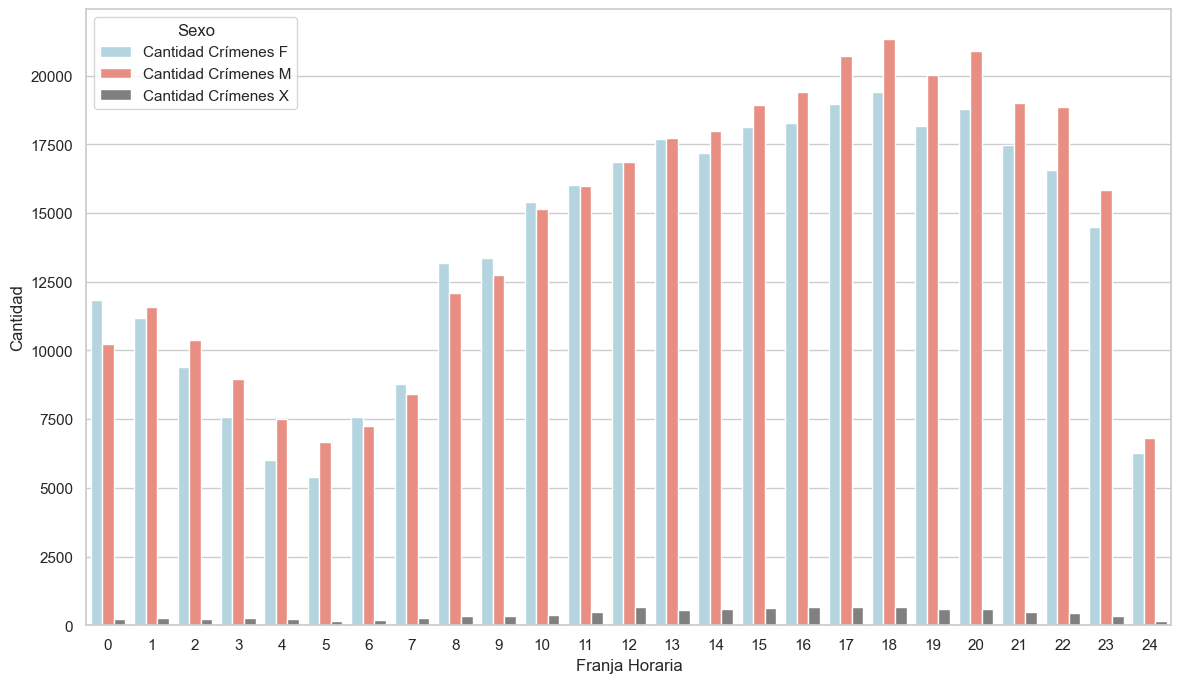

In [293]:
# Paso 1: Derretimos excluyendo 'Total'


# Paso 2: Graficamos usando SOLO df_melt
plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")

ax = sns.barplot(
    data=df_melt,  # Usá este
    x='Franja Horaria',
    y='Cantidad',
    hue='Sexo',
    palette={
        'Cantidad Crímenes F': 'lightblue',
        'Cantidad Crímenes M': 'salmon',
        'Cantidad Crímenes X': 'gray',
    }
)


Este gráfico muestra que:

Los crímenes aumentan drásticamente a partir de las 10:00 hs, alcanzando un pico entre las 16 y 22 hs, donde se mantiene relativamente alto.

En todas las franjas horarias, la cantidad de crímenes hacia víctimas masculinas es levemente superior a la de víctimas femeninas, aunque la diferencia no es extrema. Esto sugiere que ambos sexos están expuestos de manera similar, con variaciones que pueden deberse a los tipos de crimen dominantes en cada horario.

El número de víctimas con sexo registrado como “X” es ínfimo, pero constante, lo que puede indicar una categoría poco utilizada o mal registrada.

✅ Este gráfico muestra la distribución de los crímenes por sexo y hora, evidenciando que ambos géneros sufren delitos principalmente en la tarde-noche, ayudando a entender la dimensión de género en el fenómeno delictivo.

